# Final Project by Anna & Edoardo

### We estimate the values of $\Omega_m$ and $w_{DE}$ parameters using DESI BAO data + Planck $r_d$

In [1]:
import sys
sys.path.append("/home/edo/Software/TESI/AstroCosmoComputational/Students/Martinelli_Edoardo/")
import numpy as np
# Import the plotting module
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",})
# Import distances class
from pyACC.cosmology import *
# Import integration class
from pyACC.Calculus import *
from pyACC.clustering import *
import scipy as sp
import camb

In [2]:
# reading of DESI data and their management

data  =  open('DESIdata.txt', 'r')
lines = data.readlines()
lines = np.array(lines)
n     = lines.size
DATA  = np.zeros((n,n))
DATA  = np.loadtxt("DESIdata.txt")
# call of the dataDESImanager function
dataDESI, covDESI = dataDESImanager(DATA)
z_DESI = dataDESI[:,0]
DV_DESI = dataDESI[:,1]

#extractiong sigmas from the covariance matrix
deltaDESI = np.sqrt(np.diag(covDESI))

Computing data: 100%|██████████| 7/7 [00:00<00:00, 38130.04it/s]


### Part 0: Plot of Desi BAO+CMB data over our theoretical model prediction:

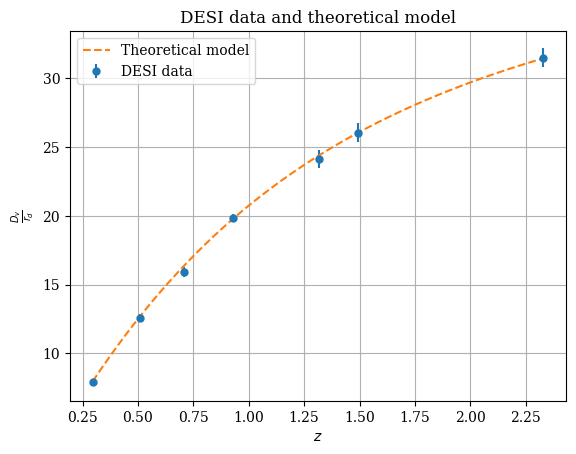

In [3]:
zs = np.linspace(np.min(z_DESI),np.max(z_DESI),1000)
DV_th = distance_volume_over_rd(zs, wde=-0.99, H0=68.52, omegaM=0.295, omegaLam=(1-0.295),omegaGamma=0,omegaNu=0,w0=0,wa=0)

plt.errorbar(z_DESI, DV_DESI, yerr=deltaDESI, fmt='o',ms=5, label='DESI data')
plt.plot(zs, DV_th, label='Theoretical model', linestyle='--')
plt.xlabel(r'$z$')
plt.ylabel(r'$\frac{D_v}{r_d}$')

plt.title('DESI data and theoretical model')
plt.grid()
plt.legend()

### Part 1: test of the implemented functions with data from a known cosmology:

The first cosmology (C1) we are working on is a wCDM model with these parameters (DESI best fit):

$\rightarrow w_{DE}$ = -0.99

$\rightarrow H_0$ = 68.52

$\rightarrow \Omega_m$ = 0.295

$\rightarrow \Omega_{\Lambda}$ = 0.705

$\rightarrow \Omega_{\gamma}$ = 0

$\rightarrow \Omega_{\nu}$ = 0


In [4]:
Om_desi=0.295
wde_desi=-0.99

In [5]:
# from our teorical implementation of distance volume we generate a random data set using
# DESI real variances as sigmas of a normal distribution centered in the theoretical value

Om_C1 = Om_desi
wde_C1 = wde_desi

# first cosmology tested (C1)
mean_DV_C1 = distance_volume_over_rd(z_DESI, wde=wde_C1, H0=68.52, omegaM=Om_C1, omegaLam=(1-Om_C1),omegaGamma=0,omegaNu=0,w0=0,wa=0)

# random normal data set from C1
data_C1 = np.random.normal(mean_DV_C1, deltaDESI)

# let's compute the dataset C1 in DESI format
zero_column = np.zeros(z_DESI.size)
DATA_C1 = np.column_stack([z_DESI, zero_column, zero_column, zero_column, zero_column, data_C1, deltaDESI]) 


In [6]:
# now we generate the distance function for the LogL generator
f_dist = lambda z, Om , wde : distance_volume_over_rd(z, wde=wde, H0=68.52, omegaM=Om, omegaLam=(1-Om), omegaGamma=0, omegaNu=0, w0=0, wa=0)

# we generate the LogL function
infs=np.array([0.01,-3])
sups=np.array([0.99,-0.5])
LogL_C1 = get_logLIKELIHOOD_flatPRIOR(DATA_C1, f_dist, infs, sups)

Computing data: 100%|██████████| 7/7 [00:00<00:00, 57344.00it/s]

Arguments of the LH function:  ['Om', 'wde']


In [7]:
# now we sample the LogL function with MH algorithm

Om_point = Om_C1
wde_point = wde_C1
X0=np.array([Om_point, wde_point])

Ds=np.array([0.01,0.01])
covmat=np.diag(Ds**2)
Nint=200000

results_C1, eff_results_C1 = Metropolis_Hastings(LogL_C1, X0, Nint, cov_mat=covmat, type='gauss', pdf_log=True)


-------------------------------
Metropolis-Hastings algorithm: 
You have inserted a distribution with these arguments:  ['*args']
-------------------------------
The starting point in parameter space is:  [ 0.295 -0.99 ]
-------------------------------
Function object created, you've inserted a  <class 'function'>  function with  0  variables


M-H, Gaussian proposal: 100%|██████████| 200000/200000 [06:09<00:00, 541.67it/s]


Removed no burn in


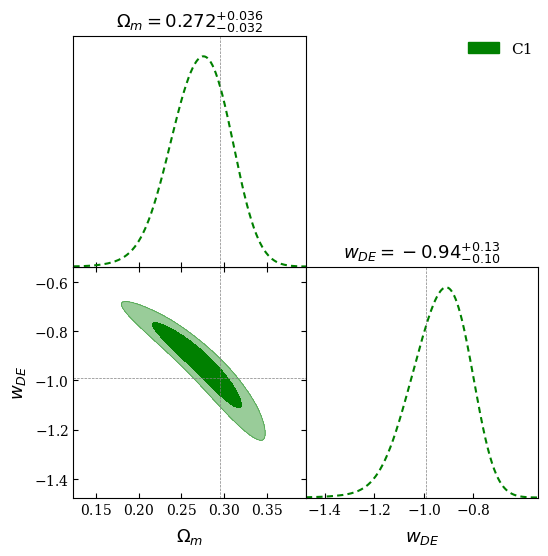

In [8]:
# let's plot the results

Om_samples_C1 = results_C1[:,0]
wde_samples_C1 = results_C1[:,1]
names_C1 = ['\Omega_m', 'w_{DE}']
labels_C1 = ['\Omega_m', 'w_{DE}']

samples_C1 = MCSamples(samples=results_C1, names=names_C1, labels=labels_C1, label='C1')

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter(subplot_size=3)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14

g.triangle_plot(samples_C1, legend_labels=['C1'], 
                filled=True,
                line_args={'ls':'--','lw':1.5, 'color':'green'},
                contour_colors=['green'], 
                legend_loc='upper right',
                title_limit=1, # first title limit (for 1D plots) is 68% by default
                markers={'\Omega_m':Om_desi, 'w_{DE}':wde_desi},)

### Part 2: test with real DESI data:

In [9]:
# now we generate the distance function for the LogL generator
f_dist_DESI = lambda z, Om , wde : distance_volume_over_rd(z, wde=wde, H0=68.52, omegaM=Om, omegaLam=(1-Om), omegaGamma=0, omegaNu=0, w0=0, wa=0)

# we generate the LogL function
infs=np.array([0.01,-3])
sups=np.array([0.99,-0.5])
LogL_DESI = get_logLIKELIHOOD_flatPRIOR(DATA, f_dist_DESI, infs, sups)

Computing data: 100%|██████████| 7/7 [00:00<00:00, 57232.22it/s]

Arguments of the LH function:  ['Om', 'wde']


In [10]:
# now we sample the LogL function with MH algorithm

# the best fit values for DESI
wde_point = wde_desi
Om_point = Om_desi 

X0=np.array([Om_point, wde_point])
Ds=np.array([0.01,0.01])
covmat=np.diag(Ds**2)

results_DESI, eff_results_DESI = Metropolis_Hastings(LogL_DESI, X0, Nint, cov_mat=covmat, type='gauss', pdf_log=True)

-------------------------------
Metropolis-Hastings algorithm: 
You have inserted a distribution with these arguments:  ['*args']
-------------------------------
The starting point in parameter space is:  [ 0.295 -0.99 ]
-------------------------------
Function object created, you've inserted a  <class 'function'>  function with  0  variables


M-H, Gaussian proposal: 100%|██████████| 200000/200000 [06:22<00:00, 522.42it/s]


Removed no burn in


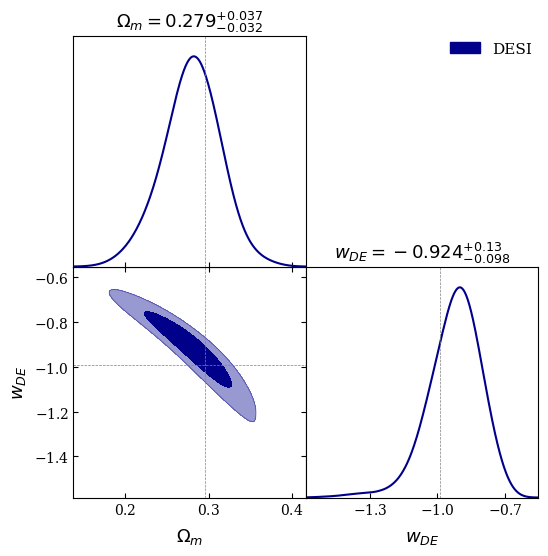

In [11]:
Om_samples_DESI = results_DESI[:,0]
wde_samples_DESI = results_DESI[:,1]

names = ['\Omega_m', 'w_{DE}']
labels = ['\Omega_m', 'w_{DE}']

samples_DESI = MCSamples(samples=results_DESI, names=names, labels=labels, label='DESI')

g = plots.get_subplot_plotter(subplot_size=3)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot(samples_DESI, legend_labels=['DESI'],
                filled=True,
                line_args={'lw':1.5, 'color':'darkblue'},
                contour_colors=['darkblue'], 
                legend_loc='upper right',
                title_limit=1, # first title limit (for 1D plots) is 68% by default
                markers={'\Omega_m':Om_desi, 'w_{DE}':wde_desi},)

### Part 3: Comparison:

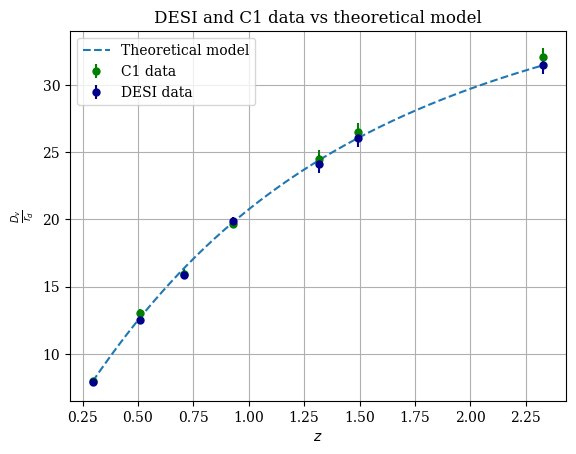

In [12]:
# let's confront C1 data with the DESI data
plt.errorbar(z_DESI, data_C1, yerr=deltaDESI, fmt='o',ms=5, label='C1 data', color='green')
plt.errorbar(z_DESI, DV_DESI, yerr=deltaDESI, fmt='o',ms=5, label='DESI data',color='darkblue')
plt.plot(zs, DV_th, label='Theoretical model', linestyle='--')
plt.xlabel(r'$z$')
plt.ylabel(r'$\frac{D_v}{r_d}$')

plt.title('DESI and C1 data vs theoretical model')
plt.grid()
plt.legend()

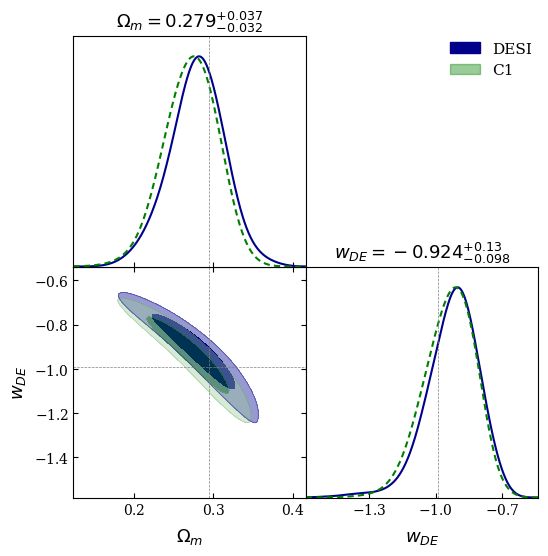

In [13]:
# let's plot the DESI results compared with the ones from C!
g = plots.get_subplot_plotter(subplot_size=3)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14


g.triangle_plot([samples_DESI,samples_C1], legend_labels=['DESI','C1'],
                filled=True,
                legend_loc='upper right',
                line_args=[{'lw':1.5, 'color':'darkblue'},
                           {'ls':'--','lw':1.5, 'color':'green'}], 
                contour_colors=['darkblue','green'],
                title_limit=1, # first title limit (for 1D plots) is 68% by default
                markers={'\Omega_m':Om_desi, 'w_{DE}':wde_desi},)